In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch.optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader
from learned_ctrlr_opt.utils.learning_utils import init_weights, create_network
from datetime import datetime
import wandb
import os
import hydra
from omegaconf import OmegaConf
from scipy.optimize import minimize, basinhopping
from rotorpy.wind.default_winds import ConstantWind
import time
from learned_ctrlr_opt.utils.experiment_utils import *

from learned_ctrlr_opt.meta_learning.lsr_net import *
from learned_ctrlr_opt.meta_learning.reptile_net import *
from learned_ctrlr_opt.meta_learning.basis_kf import *
from learned_ctrlr_opt.meta_learning.utils import get_sysid_history_dataset, get_scalers
from learned_ctrlr_opt.opt.optimize_thru_network import *
from learned_ctrlr_opt.opt.random_search import *
from learned_ctrlr_opt.opt.particle_search import particle_search
from learned_ctrlr_opt.systems.quadrotor_geom import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

Cannot use pydrake on this system. Quadrotor2d will not work


# Quadrotor

In [116]:
kf_checkpoint_dir = "model_checkpoints/crazyflie_geom_history_lstsq_net/sparkling-sponge-354_Dec_27_2023/"
# kf_checkpoint_dir = "model_checkpoints/crazyflie_geom_history_lstsq_net/zesty-brook-355_Dec_27_2023/"

reptile_checkpoint_dir = "model_checkpoints/crazyflie_geom_history_reptile_net/devout-puddle-384_Jan_06_2024/"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

kf_cfg = OmegaConf.load(os.path.join(kf_checkpoint_dir, "config.yaml"))
reptile_cfg = OmegaConf.load(os.path.join(reptile_checkpoint_dir, "config.yaml"))

# load scalers
scalers = get_scalers(kf_cfg.path_to_dataset, kf_cfg.history_length, kf_cfg.metric_idxs, kf_cfg.metric_idxs_to_invert)
history_scaler = scalers[-1]
gain_scaler = scalers[0]
metric_scaler = scalers[2]

gain_dim = len(kf_cfg.gains_to_optimize)
history_in_size = kf_cfg.history_length * kf_cfg.traj_dim
kf_cfg = OmegaConf.load(os.path.join(kf_checkpoint_dir, "config.yaml"))

kf_network = LSRBasisNet_encoder(gain_in_size=gain_dim,
                                 n_bases=kf_cfg.n_bases,
                                 n_targets=len(kf_cfg.metric_idxs),
                                 history_in_size=history_in_size,
                                 history_out_size=kf_cfg.history_latent_dim,
                                 encoder_layer_sizes=kf_cfg.encoder_layer_sizes,
                                 encoder_nonlin=kf_cfg.encoder_nonlin,
                                 layer_sizes=kf_cfg.layer_sizes,
                                 nonlin=kf_cfg.nonlin).float().train().to(device)

reptile_net = ReptileModel_Encoder(
    in_size = gain_dim,
    n_targets=len(reptile_cfg.metric_idxs),
    history_in_size=reptile_cfg.history_length * reptile_cfg.traj_dim,
    history_out_size=reptile_cfg.history_latent_dim,
    encoder_layer_sizes=reptile_cfg.encoder_layer_sizes,
    encoder_nonlin=reptile_cfg.encoder_nonlin,
    layer_sizes=reptile_cfg.layer_sizes,
    nonlin=reptile_cfg.nonlin).float().to(device)

reptile_net.load_state_dict(torch.load(os.path.join(reptile_checkpoint_dir, "model_epoch_30.pt")))

kf_network.load_state_dict(torch.load(os.path.join(kf_checkpoint_dir, "model_epoch_90.pt")))
kf_network.use_last_layer = False
kf_network = kf_network.eval().to(device)

cost_weights = np.array([0.5, 0.1, 0.3, 0.1])
sigma_weight = 0.05


num_trials = 63
num_replay_steps = 0
wind_obj = ConstantWind(0.0, 0, 0)

# Load Test Set

In [122]:
dset_f = h5py.File("priors/quad_geom_rss_sysid_data/crazyflie/quad_geom_rss_traj_dataset_Aug_05_2024_1945/dataset.hdf5", 'r')
# dset_f = h5py.File(kf_cfg.path_to_dataset, 'r')

test_thetas = np.array(dset_f["intrinsics"])
test_gains = np.array(dset_f["gains"])
test_metrics = np.array(dset_f["metrics"])
test_histories = np.array(dset_f["initial_trajectories"])
dset_f.close()

num_params_to_test = 80

# Test KF Prediction Performance

In [123]:
kf_network.use_last_layer = False

expected_costs = np.zeros((num_params_to_test, num_trials, 1))
expected_variances = np.zeros((num_params_to_test, num_trials, 1))
actual_costs = np.zeros((num_params_to_test, num_trials, 1))
all_weights = np.zeros((num_params_to_test, num_trials, kf_cfg.n_bases))
expected_scaled_metrics = np.zeros((num_params_to_test, num_trials, len(kf_cfg.metric_idxs)))
actual_scaled_metrics = np.zeros((num_params_to_test, num_trials, len(kf_cfg.metric_idxs)))
failed_count = 0

for p_idx in range(num_params_to_test):
    print(f"ON p_idx {p_idx}")

    weights = kf_network.last_layer_prior
    sigma = torch.mm(kf_network.last_layer_prior_cov_sqrt, torch.t(kf_network.last_layer_prior_cov_sqrt))
    Q = torch.mm(kf_network.Q_sqrt, torch.t(kf_network.Q_sqrt))
    R = torch.mm(kf_network.R_sqrt, torch.t(kf_network.R_sqrt))

    task_input_data = torch.zeros(num_trials, gain_dim+history_in_size)
    task_target_data = torch.zeros(num_trials, len(kf_cfg.metric_idxs))
    particles_torch = None
    for i in range(num_trials):
        all_weights[p_idx, i] = weights.cpu().detach().numpy()
        def eval_fn(x, cost_weights, sigma_weight):
            q = x.size(0)
            cost_weights = torch.from_numpy(cost_weights).float().to(device)
            ys, sigmas = last_layer_prediction_uncertainty_aware(x, kf_network, weights, sigma)
            cost_weights_batch = cost_weights.repeat(q).reshape((q, cost_weights.shape[-1])).to(device)
            mean_losses = torch.sum(ys * cost_weights_batch, dim=-1)
            variances = torch.zeros(x.size(0)).to(device)
            for j in range(x.size(0)):
                inter = torch.mm(sigmas[j], cost_weights.unsqueeze(-1))
                variances[j] = torch.mm(torch.t(cost_weights.unsqueeze(-1)), inter)
            losses = mean_losses + sigma_weight * variances
            return losses, ys, variances

        traj_lim = test_histories[p_idx,i,-kf_cfg.history_length:]
        traj_lim = np.expand_dims(traj_lim, 0)
        traj_rs = traj_lim.reshape(-1, traj_lim.shape[-1])
        traj_scaled = history_scaler.transform(traj_rs)
        traj_flat = np.squeeze(traj_scaled.reshape(traj_lim.shape[0], -1))

        best_gain = torch.from_numpy(gain_scaler.transform(test_gains[p_idx,i].reshape(1,-1))).squeeze()
        best_gain_unscaled = test_gains[p_idx,i]
#         best_gain_unscaled = np.squeeze(gain_scaler.inverse_transform(best_gain.detach().cpu().numpy().reshape(1, -1)))
#         print(f"---- Step {i} ----")
#         print(f"best_gain_unscaled = {best_gain_unscaled}")
#         perf_metrics, traj, env = robot.evaluate_x(best_gain_unscaled, env, render=False, wind=wind_obj)
        perf_metrics = test_metrics[p_idx,i]
#         print(f"perf metrics were {perf_metrics}")
        perf_metrics[...,kf_cfg.metric_idxs_to_invert] = 1/(1 + perf_metrics[...,kf_cfg.metric_idxs_to_invert])
#         raw_metrics[p_idx, i] = perf_metrics
#         print(f"scaled perf metrics were {metric_scaler.transform(perf_metrics[kf_cfg.metric_idxs].reshape(1, -1)).squeeze()}")
        true_y_scaled = np.dot(cost_weights, metric_scaler.transform(perf_metrics[kf_cfg.metric_idxs].reshape(1, -1)).squeeze())

        input_test = torch.cat([best_gain, torch.from_numpy(traj_flat)], dim=-1).unsqueeze(0)
        best_y_mean, best_y_sigma = last_layer_prediction_uncertainty_aware(input_test, kf_network, weights, sigma)

        expected_costs[p_idx, i] = np.dot(cost_weights, best_y_mean.cpu().detach().numpy().squeeze())
        actual_costs[p_idx, i] = true_y_scaled
        actual_scaled_metrics[p_idx, i] = metric_scaler.transform(perf_metrics[kf_cfg.metric_idxs].reshape(1, -1)).squeeze()

        input_test = torch.cat([best_gain, torch.from_numpy(traj_flat)], dim=-1).unsqueeze(0)
        best_y_mean, best_y_sigma = last_layer_prediction_uncertainty_aware(input_test, kf_network, weights, sigma)
        expected_scaled_metrics[p_idx, i] = best_y_mean.cpu().detach().numpy()
        expected_variances[p_idx, i] = cost_weights.T @ best_y_sigma.cpu().detach().numpy() @ cost_weights

        inp = torch.cat([best_gain, torch.from_numpy(traj_flat)], dim=-1)
        phi = kf_network(inp.unsqueeze(0).float().to(device)).squeeze().detach()
        target = torch.from_numpy(metric_scaler.transform(perf_metrics[kf_cfg.metric_idxs].reshape(1, -1)).squeeze())
        task_input_data[i] = inp
        task_target_data[i] = target
        with torch.no_grad():
            weights, sigma, K = kalman_step(weights, sigma, target.float().to(device), phi, Q, R)

ON p_idx 0
ON p_idx 1
ON p_idx 2
ON p_idx 3
ON p_idx 4
ON p_idx 5
ON p_idx 6
ON p_idx 7
ON p_idx 8
ON p_idx 9
ON p_idx 10
ON p_idx 11
ON p_idx 12
ON p_idx 13
ON p_idx 14
ON p_idx 15
ON p_idx 16
ON p_idx 17
ON p_idx 18
ON p_idx 19
ON p_idx 20
ON p_idx 21
ON p_idx 22
ON p_idx 23
ON p_idx 24
ON p_idx 25
ON p_idx 26
ON p_idx 27
ON p_idx 28
ON p_idx 29
ON p_idx 30
ON p_idx 31
ON p_idx 32
ON p_idx 33
ON p_idx 34
ON p_idx 35
ON p_idx 36
ON p_idx 37
ON p_idx 38
ON p_idx 39
ON p_idx 40
ON p_idx 41
ON p_idx 42
ON p_idx 43
ON p_idx 44
ON p_idx 45
ON p_idx 46
ON p_idx 47
ON p_idx 48
ON p_idx 49
ON p_idx 50
ON p_idx 51
ON p_idx 52
ON p_idx 53
ON p_idx 54
ON p_idx 55
ON p_idx 56
ON p_idx 57
ON p_idx 58
ON p_idx 59
ON p_idx 60
ON p_idx 61
ON p_idx 62
ON p_idx 63
ON p_idx 64
ON p_idx 65
ON p_idx 66
ON p_idx 67
ON p_idx 68
ON p_idx 69
ON p_idx 70
ON p_idx 71
ON p_idx 72
ON p_idx 73
ON p_idx 74
ON p_idx 75
ON p_idx 76
ON p_idx 77
ON p_idx 78
ON p_idx 79


Text(0.5, 0, 'Iteration')

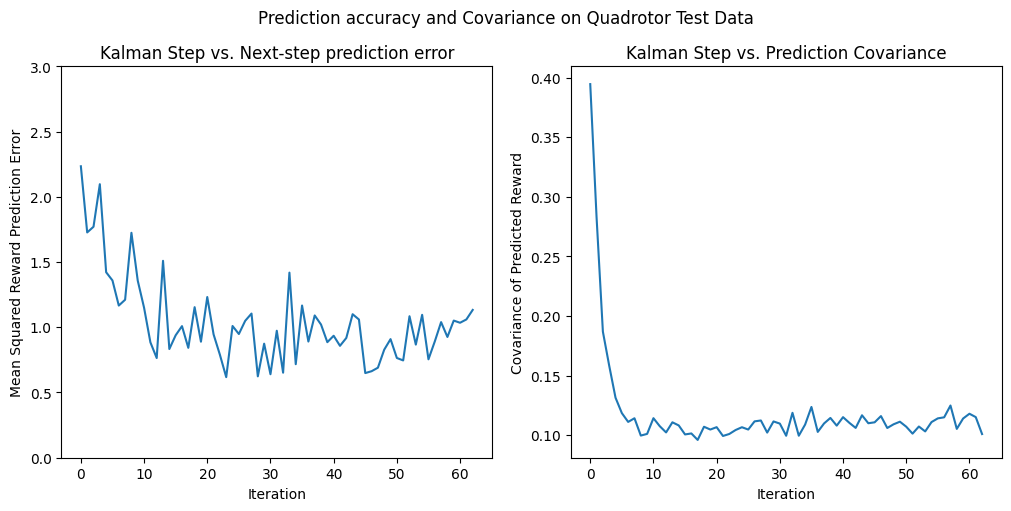

In [124]:
fig, ax = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
fig.suptitle("Prediction accuracy and Covariance on Quadrotor Test Data")
ax[0].plot(np.mean((actual_costs - expected_costs)**2, axis=0))
ax[0].set_ylim(0, 3)
ax[0].set_ylabel("Mean Squared Reward Prediction Error")
ax[0].set_xlabel("Iteration")
ax[0].set_title("Kalman Step vs. Next-step prediction error")


ax[1].plot(np.mean((expected_variances), axis=0))
ax[1].set_title("Kalman Step vs. Prediction Covariance")
ax[1].set_ylabel("Covariance of Predicted Reward")
ax[1].set_xlabel("Iteration")

# Test Reptile Performance

In [45]:
expected_costs_reptile = np.zeros((num_params_to_test, num_trials, 1))
actual_costs_reptile = np.zeros((num_params_to_test, num_trials, 1))
expected_scaled_metrics_reptile = np.zeros((num_params_to_test, num_trials, len(kf_cfg.metric_idxs)))
actual_scaled_metrics_reptile = np.zeros((num_params_to_test, num_trials, len(kf_cfg.metric_idxs)))

for p_idx in range(num_params_to_test):
    print(f"ON p_idx {p_idx}")
    # best_gain = initial_gain_scaled
    adapted_net = reptile_net
    
    task_input_data = torch.zeros(num_trials, gain_dim+history_in_size)
    task_target_data = torch.zeros(num_trials, len(reptile_cfg.metric_idxs))
    for i in range(num_trials):
        traj_lim = test_histories[p_idx,i,-kf_cfg.history_length:]
        traj_lim = np.expand_dims(traj_lim, 0)
        traj_rs = traj_lim.reshape(-1, traj_lim.shape[-1])
        traj_scaled = history_scaler.transform(traj_rs)
        traj_flat = np.squeeze(traj_scaled.reshape(traj_lim.shape[0], -1))

        best_gain = torch.from_numpy(gain_scaler.transform(test_gains[p_idx,i].reshape(1,-1))).squeeze()
        best_gain_unscaled = test_gains[p_idx,i]
        perf_metrics = test_metrics[p_idx,i]
        perf_metrics[...,reptile_cfg.metric_idxs_to_invert] = 1/(1 + perf_metrics[...,reptile_cfg.metric_idxs_to_invert])
        true_y_scaled = np.dot(cost_weights, metric_scaler.transform(perf_metrics[reptile_cfg.metric_idxs].reshape(1, -1)).squeeze())
        
        best_y_metrics = adapted_net(torch.cat([best_gain.detach(), torch.from_numpy(traj_flat).detach()], dim=-1).float().unsqueeze(0).to(device)).squeeze()
        expected_scaled_metrics_reptile[p_idx,i] = best_y_metrics.detach().cpu().numpy()
        expected_costs_reptile[p_idx, i] = np.dot(cost_weights, best_y_metrics.detach().cpu().numpy())
        
        actual_costs_reptile[p_idx, i] = true_y_scaled

        task_input_data[i] = torch.cat([best_gain.detach(), torch.from_numpy(traj_flat).detach()], dim=-1).float()
        task_target_data[i] = torch.from_numpy(metric_scaler.transform(perf_metrics[reptile_cfg.metric_idxs].reshape(1, -1)).squeeze()).float()
        adapted_net = adapt_reptile(task_input_data[:i+1],
                                    task_target_data[:i+1],
                                    reptile_net,
                                    reptile_cfg.inner_lr,
                                    10)


ON p_idx 0
ON p_idx 1
ON p_idx 2
ON p_idx 3
ON p_idx 4
ON p_idx 5
ON p_idx 6
ON p_idx 7
ON p_idx 8
ON p_idx 9
ON p_idx 10
ON p_idx 11
ON p_idx 12
ON p_idx 13
ON p_idx 14
ON p_idx 15
ON p_idx 16
ON p_idx 17
ON p_idx 18
ON p_idx 19
ON p_idx 20
ON p_idx 21
ON p_idx 22
ON p_idx 23
ON p_idx 24
ON p_idx 25
ON p_idx 26
ON p_idx 27
ON p_idx 28
ON p_idx 29
ON p_idx 30
ON p_idx 31
ON p_idx 32
ON p_idx 33
ON p_idx 34
ON p_idx 35
ON p_idx 36
ON p_idx 37
ON p_idx 38
ON p_idx 39
ON p_idx 40
ON p_idx 41
ON p_idx 42
ON p_idx 43
ON p_idx 44
ON p_idx 45
ON p_idx 46
ON p_idx 47
ON p_idx 48
ON p_idx 49
ON p_idx 50
ON p_idx 51
ON p_idx 52
ON p_idx 53
ON p_idx 54
ON p_idx 55
ON p_idx 56
ON p_idx 57
ON p_idx 58
ON p_idx 59
ON p_idx 60
ON p_idx 61
ON p_idx 62
ON p_idx 63
ON p_idx 64
ON p_idx 65
ON p_idx 66
ON p_idx 67
ON p_idx 68
ON p_idx 69
ON p_idx 70
ON p_idx 71
ON p_idx 72
ON p_idx 73
ON p_idx 74
ON p_idx 75
ON p_idx 76
ON p_idx 77
ON p_idx 78
ON p_idx 79


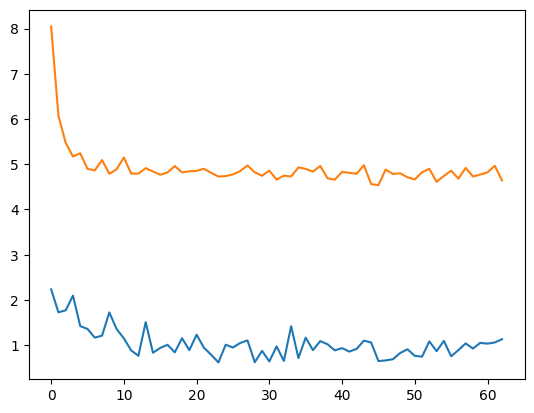

In [47]:
plt.plot(np.mean((actual_costs - expected_costs)**2, axis=0))
plt.plot(np.mean((actual_costs_reptile - expected_costs_reptile)**2, axis=0))

# Top Down Car

In [109]:
# Load KF
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

kf_checkpoint_dir = "model_checkpoints/top_down_car_history_lstsq_net/woven-water-348_Dec_26_2023/"
kf_cfg = OmegaConf.load(os.path.join(kf_checkpoint_dir, "config.yaml"))
# load scalers
scalers = get_scalers(kf_cfg.path_to_dataset, kf_cfg.history_length, kf_cfg.metric_idxs, kf_cfg.metric_idxs_to_invert)
history_scaler = scalers[-1]
gain_scaler = scalers[0]
metric_scaler = scalers[2]

dset_f = h5py.File(kf_cfg.path_to_dataset, 'r')
ref_tracks_enc = np.array(dset_f["reference_tracks_enc"])
ref_track_scaler = MinMaxScaler(clip=True).fit(ref_tracks_enc.reshape(-1, 1))
dset_f.close()

gain_dim = len(kf_cfg.gains_to_optimize)
lookahead_dim = 25
history_in_size = kf_cfg.history_length * kf_cfg.traj_dim
kf_cfg = OmegaConf.load(os.path.join(kf_checkpoint_dir, "config.yaml"))

kf_network = LSRBasisNet_encoder(gain_in_size=gain_dim+lookahead_dim,
                                 n_bases=kf_cfg.n_bases,
                                 n_targets=len(kf_cfg.metric_idxs),
                                 history_in_size=history_in_size,
                                 history_out_size=kf_cfg.history_latent_dim,
                                 encoder_layer_sizes=kf_cfg.encoder_layer_sizes,
                                 encoder_nonlin=kf_cfg.encoder_nonlin,
                                 layer_sizes=kf_cfg.layer_sizes,
                                 nonlin=kf_cfg.nonlin).float().train().to(device)

kf_network.load_state_dict(torch.load(os.path.join(kf_checkpoint_dir, "model_epoch_100.pt")))
kf_network.use_last_layer = False
kf_network = kf_network.eval().to(device)

In [113]:
# Load dataset

dset_f = h5py.File("priors/tdc_resetfree_sysid_data/tdc_rss_traj_dataset_Aug_05_2024_1838/dataset.hdf5", 'r')
# dset_f = h5py.File(kf_cfg.path_to_dataset, 'r')
test_thetas = np.array(dset_f["intrinsics"])
test_gains = np.array(dset_f["gains"])
test_metrics = np.array(dset_f["metrics"])
test_histories = np.array(dset_f["initial_trajectories"])
test_ref_tracks = np.array(dset_f["reference_tracks_enc"])
dset_f.close()

num_params_to_test = 80
num_trials = 63

cost_weights = np.array([0.8, 0.1, 0.1])

In [114]:
kf_network.use_last_layer = False

expected_costs = np.zeros((num_params_to_test, num_trials, 1))
expected_variances = np.zeros((num_params_to_test, num_trials, 1))
actual_costs = np.zeros((num_params_to_test, num_trials, 1))
all_weights = np.zeros((num_params_to_test, num_trials, kf_cfg.n_bases))
expected_scaled_metrics = np.zeros((num_params_to_test, num_trials, len(kf_cfg.metric_idxs)))
actual_scaled_metrics = np.zeros((num_params_to_test, num_trials, len(kf_cfg.metric_idxs)))
failed_count = 0

for p_idx in range(num_params_to_test):
    print(f"ON p_idx {p_idx}")

    weights = kf_network.last_layer_prior
    sigma = torch.mm(kf_network.last_layer_prior_cov_sqrt, torch.t(kf_network.last_layer_prior_cov_sqrt))
    Q = torch.mm(kf_network.Q_sqrt, torch.t(kf_network.Q_sqrt))
    R = torch.mm(kf_network.R_sqrt, torch.t(kf_network.R_sqrt))

    task_input_data = torch.zeros(num_trials, gain_dim+25+history_in_size)
    task_target_data = torch.zeros(num_trials, len(kf_cfg.metric_idxs))
    particles_torch = None
    for i in range(num_trials):
        all_weights[p_idx, i] = weights.cpu().detach().numpy()
        def eval_fn(x, cost_weights, sigma_weight):
            q = x.size(0)
            cost_weights = torch.from_numpy(cost_weights).float().to(device)
            ys, sigmas = last_layer_prediction_uncertainty_aware(x, kf_network, weights, sigma)
            cost_weights_batch = cost_weights.repeat(q).reshape((q, cost_weights.shape[-1])).to(device)
            mean_losses = torch.sum(ys * cost_weights_batch, dim=-1)
            variances = torch.zeros(x.size(0)).to(device)
            for j in range(x.size(0)):
                inter = torch.mm(sigmas[j], cost_weights.unsqueeze(-1))
                variances[j] = torch.mm(torch.t(cost_weights.unsqueeze(-1)), inter)
            losses = mean_losses + sigma_weight * variances
            return losses, ys, variances

        traj_lim = test_histories[p_idx,i,-kf_cfg.history_length:]
        traj_lim = np.expand_dims(traj_lim, 0)
        traj_rs = traj_lim.reshape(-1, traj_lim.shape[-1])
        traj_scaled = history_scaler.transform(traj_rs)
        traj_flat = np.squeeze(traj_scaled.reshape(traj_lim.shape[0], -1))
        track_lookahead = ref_track_scaler.transform(test_ref_tracks[p_idx, i, ::3].reshape(-1,1)).squeeze()
        track_ahead_pp_torch = torch.from_numpy(track_lookahead)
        
        best_gain = torch.from_numpy(gain_scaler.transform(test_gains[p_idx,i].reshape(1,-1))).squeeze()
        best_gain_unscaled = test_gains[p_idx,i]
        perf_metrics = test_metrics[p_idx,i]
        perf_metrics[...,kf_cfg.metric_idxs_to_invert] = 1/(1 + perf_metrics[...,kf_cfg.metric_idxs_to_invert])
        true_y_scaled = np.dot(cost_weights, metric_scaler.transform(perf_metrics[kf_cfg.metric_idxs].reshape(1, -1)).squeeze())

        input_test = torch.cat([best_gain, track_ahead_pp_torch, torch.from_numpy(traj_flat)], dim=-1).unsqueeze(0)
        best_y_mean, best_y_sigma = last_layer_prediction_uncertainty_aware(input_test, kf_network, weights, sigma)

        expected_costs[p_idx, i] = np.dot(cost_weights, best_y_mean.cpu().detach().numpy().squeeze())
        actual_costs[p_idx, i] = true_y_scaled
        actual_scaled_metrics[p_idx, i] = metric_scaler.transform(perf_metrics[kf_cfg.metric_idxs].reshape(1, -1)).squeeze()

#         input_test = torch.cat([best_gain, track_ahead_pp_torch, torch.from_numpy(traj_flat)], dim=-1).unsqueeze(0)
#         best_y_mean, best_y_sigma = last_layer_prediction_uncertainty_aware(input_test, kf_network, weights, sigma)
        expected_scaled_metrics[p_idx, i] = best_y_mean.cpu().detach().numpy()
        expected_variances[p_idx, i] = cost_weights.T @ best_y_sigma.cpu().detach().numpy() @ cost_weights

        inp = torch.cat([best_gain, track_ahead_pp_torch, torch.from_numpy(traj_flat)], dim=-1)
        phi = kf_network(inp.unsqueeze(0).float().to(device)).squeeze().detach()
        target = torch.from_numpy(metric_scaler.transform(perf_metrics[kf_cfg.metric_idxs].reshape(1, -1)).squeeze())
        task_input_data[i] = inp
        task_target_data[i] = target
        with torch.no_grad():
            weights, sigma, K = kalman_step(weights, sigma, target.float().to(device), phi, Q, R)

ON p_idx 0
ON p_idx 1
ON p_idx 2
ON p_idx 3
ON p_idx 4
ON p_idx 5
ON p_idx 6
ON p_idx 7
ON p_idx 8
ON p_idx 9
ON p_idx 10
ON p_idx 11
ON p_idx 12
ON p_idx 13
ON p_idx 14
ON p_idx 15
ON p_idx 16
ON p_idx 17
ON p_idx 18
ON p_idx 19
ON p_idx 20
ON p_idx 21
ON p_idx 22
ON p_idx 23
ON p_idx 24
ON p_idx 25
ON p_idx 26
ON p_idx 27
ON p_idx 28
ON p_idx 29
ON p_idx 30
ON p_idx 31
ON p_idx 32
ON p_idx 33
ON p_idx 34
ON p_idx 35
ON p_idx 36
ON p_idx 37
ON p_idx 38
ON p_idx 39
ON p_idx 40
ON p_idx 41
ON p_idx 42
ON p_idx 43
ON p_idx 44
ON p_idx 45
ON p_idx 46
ON p_idx 47
ON p_idx 48
ON p_idx 49
ON p_idx 50
ON p_idx 51
ON p_idx 52
ON p_idx 53
ON p_idx 54
ON p_idx 55
ON p_idx 56
ON p_idx 57
ON p_idx 58
ON p_idx 59
ON p_idx 60
ON p_idx 61
ON p_idx 62
ON p_idx 63
ON p_idx 64
ON p_idx 65
ON p_idx 66
ON p_idx 67
ON p_idx 68
ON p_idx 69
ON p_idx 70
ON p_idx 71
ON p_idx 72
ON p_idx 73
ON p_idx 74
ON p_idx 75
ON p_idx 76
ON p_idx 77
ON p_idx 78
ON p_idx 79


Text(0.5, 0, 'Iteration')

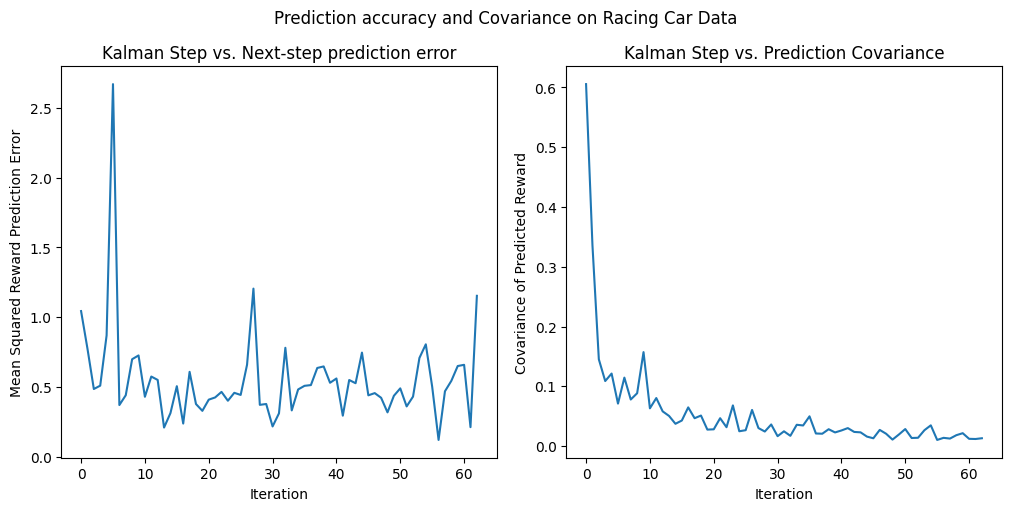

In [115]:
fig, ax = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
fig.suptitle("Prediction accuracy and Covariance on Racing Car Data")
ax[0].plot(np.mean((actual_costs - expected_costs)**2, axis=0))
# ax[0].set_ylim(0, 3)
ax[0].set_ylabel("Mean Squared Reward Prediction Error")
ax[0].set_xlabel("Iteration")
ax[0].set_title("Kalman Step vs. Next-step prediction error")


ax[1].plot(np.mean((expected_variances), axis=0))
ax[1].set_title("Kalman Step vs. Prediction Covariance")
ax[1].set_ylabel("Covariance of Predicted Reward")
ax[1].set_xlabel("Iteration")
# fig.tight_layout()

# Test MoB Performance

In [90]:
kf_checkpoint_dir = "model_checkpoints/mob_loco_lstsq_net/lemon-dragon-409_Jan_25_2024/"
kf_cfg = OmegaConf.load(os.path.join(kf_checkpoint_dir, "config.yaml"))
# load scalers
scalers = get_scalers(kf_cfg.path_to_dataset, kf_cfg.history_length, kf_cfg.metric_idxs, kf_cfg.metric_idxs_to_invert)
# pca_x, pca_y, ref_track_scaler = get_ref_track_pcas_and_scaler(kf_cfg.path_to_dataset, "reference_tracks", 10)
history_scaler = scalers[-1]
gain_scaler = scalers[0]
metric_scaler = scalers[2]

gain_dim = len(kf_cfg.gains_to_optimize)
lookahead_dim = 3
history_in_size = kf_cfg.history_length * kf_cfg.traj_dim
kf_cfg = OmegaConf.load(os.path.join(kf_checkpoint_dir, "config.yaml"))

kf_network = LSRBasisNet_encoder(gain_in_size=gain_dim+lookahead_dim,
                                 n_bases=kf_cfg.n_bases,
                                 n_targets=len(kf_cfg.metric_idxs),
                                 history_in_size=history_in_size,
                                 history_out_size=kf_cfg.history_latent_dim,
                                 encoder_layer_sizes=kf_cfg.encoder_layer_sizes,
                                 encoder_nonlin=kf_cfg.encoder_nonlin,
                                 layer_sizes=kf_cfg.layer_sizes,
                                 nonlin=kf_cfg.nonlin).float().train().to(device)

kf_network.load_state_dict(torch.load(os.path.join(kf_checkpoint_dir, "model_epoch_80.pt")))
kf_network.use_last_layer = False
kf_network = kf_network.eval().to(device)

dset_f = h5py.File(kf_cfg.path_to_dataset, 'r')
ref_tracks_enc = np.array(dset_f["reference_tracks_enc"])
ref_track_scaler = MinMaxScaler(clip=True).fit(ref_tracks_enc.reshape(-1, lookahead_dim))
dset_f.close()


In [91]:
dset_f = h5py.File("priors/mob_locomotion_sysid_data/mob_loco_resetfree_dataAug_05_2024_2102/dataset.hdf5", 'r')
# dset_f = h5py.File(kf_cfg.path_to_dataset, 'r')
test_thetas = np.array(dset_f["intrinsics"])
test_gains = np.array(dset_f["gains"])
test_metrics = np.array(dset_f["metrics"])
test_histories = np.array(dset_f["initial_trajectories"])
test_ref_tracks = np.array(dset_f["reference_tracks_enc"])
dset_f.close()

num_params_to_test = 80
num_trials = 63

cost_weights = np.array([0.3, 0.3, 0.3, 0.1])

In [92]:
kf_network.use_last_layer = False

expected_costs = np.zeros((num_params_to_test, num_trials, 1))
expected_variances = np.zeros((num_params_to_test, num_trials, 1))
actual_costs = np.zeros((num_params_to_test, num_trials, 1))
all_weights = np.zeros((num_params_to_test, num_trials, kf_cfg.n_bases))
expected_scaled_metrics = np.zeros((num_params_to_test, num_trials, len(kf_cfg.metric_idxs)))
actual_scaled_metrics = np.zeros((num_params_to_test, num_trials, len(kf_cfg.metric_idxs)))
failed_count = 0

for p_idx in range(num_params_to_test):
    print(f"ON p_idx {p_idx}")

    weights = kf_network.last_layer_prior
    sigma = torch.mm(kf_network.last_layer_prior_cov_sqrt, torch.t(kf_network.last_layer_prior_cov_sqrt))
    Q = torch.mm(kf_network.Q_sqrt, torch.t(kf_network.Q_sqrt))
    R = torch.mm(kf_network.R_sqrt, torch.t(kf_network.R_sqrt))

    task_input_data = torch.zeros(num_trials, gain_dim+3+history_in_size)
    task_target_data = torch.zeros(num_trials, len(kf_cfg.metric_idxs))
    particles_torch = None
    for i in range(num_trials):
        all_weights[p_idx, i] = weights.cpu().detach().numpy()
        def eval_fn(x, cost_weights, sigma_weight):
            q = x.size(0)
            cost_weights = torch.from_numpy(cost_weights).float().to(device)
            ys, sigmas = last_layer_prediction_uncertainty_aware(x, kf_network, weights, sigma)
            cost_weights_batch = cost_weights.repeat(q).reshape((q, cost_weights.shape[-1])).to(device)
            mean_losses = torch.sum(ys * cost_weights_batch, dim=-1)
            variances = torch.zeros(x.size(0)).to(device)
            for j in range(x.size(0)):
                inter = torch.mm(sigmas[j], cost_weights.unsqueeze(-1))
                variances[j] = torch.mm(torch.t(cost_weights.unsqueeze(-1)), inter)
            losses = mean_losses + sigma_weight * variances
            return losses, ys, variances

        traj_lim = test_histories[p_idx,i,-kf_cfg.history_length:]
        traj_lim = np.expand_dims(traj_lim, 0)
        traj_rs = traj_lim.reshape(-1, traj_lim.shape[-1])
        traj_scaled = history_scaler.transform(traj_rs)
        traj_flat = np.squeeze(traj_scaled.reshape(traj_lim.shape[0], -1))
        track_lookahead = ref_track_scaler.transform(test_ref_tracks[p_idx, i].reshape(1,-1)).squeeze()
        track_ahead_pp_torch = torch.from_numpy(track_lookahead)
        
        best_gain = torch.from_numpy(gain_scaler.transform(test_gains[p_idx,i].reshape(1,-1))).squeeze()
        best_gain_unscaled = test_gains[p_idx,i]
        perf_metrics = test_metrics[p_idx,i]
        perf_metrics[...,kf_cfg.metric_idxs_to_invert] = 1/(1 + perf_metrics[...,kf_cfg.metric_idxs_to_invert])
        true_y_scaled = np.dot(cost_weights, metric_scaler.transform(perf_metrics[kf_cfg.metric_idxs].reshape(1, -1)).squeeze())

        input_test = torch.cat([best_gain, track_ahead_pp_torch, torch.from_numpy(traj_flat)], dim=-1).unsqueeze(0)
        best_y_mean, best_y_sigma = last_layer_prediction_uncertainty_aware(input_test, kf_network, weights, sigma)

        expected_costs[p_idx, i] = np.dot(cost_weights, best_y_mean.cpu().detach().numpy().squeeze())
        actual_costs[p_idx, i] = true_y_scaled
        actual_scaled_metrics[p_idx, i] = metric_scaler.transform(perf_metrics[kf_cfg.metric_idxs].reshape(1, -1)).squeeze()

#         input_test = torch.cat([best_gain, track_ahead_pp_torch, torch.from_numpy(traj_flat)], dim=-1).unsqueeze(0)
#         best_y_mean, best_y_sigma = last_layer_prediction_uncertainty_aware(input_test, kf_network, weights, sigma)
        expected_scaled_metrics[p_idx, i] = best_y_mean.cpu().detach().numpy()
        expected_variances[p_idx, i] = cost_weights.T @ best_y_sigma.cpu().detach().numpy() @ cost_weights

        inp = torch.cat([best_gain, track_ahead_pp_torch, torch.from_numpy(traj_flat)], dim=-1)
        phi = kf_network(inp.unsqueeze(0).float().to(device)).squeeze().detach()
        target = torch.from_numpy(metric_scaler.transform(perf_metrics[kf_cfg.metric_idxs].reshape(1, -1)).squeeze())
        task_input_data[i] = inp
        task_target_data[i] = target
        with torch.no_grad():
            weights, sigma, K = kalman_step(weights, sigma, target.float().to(device), phi, Q, R)

ON p_idx 0
ON p_idx 1
ON p_idx 2
ON p_idx 3
ON p_idx 4
ON p_idx 5
ON p_idx 6
ON p_idx 7
ON p_idx 8
ON p_idx 9
ON p_idx 10
ON p_idx 11
ON p_idx 12
ON p_idx 13
ON p_idx 14
ON p_idx 15
ON p_idx 16
ON p_idx 17
ON p_idx 18
ON p_idx 19
ON p_idx 20
ON p_idx 21
ON p_idx 22
ON p_idx 23
ON p_idx 24
ON p_idx 25
ON p_idx 26
ON p_idx 27
ON p_idx 28
ON p_idx 29
ON p_idx 30
ON p_idx 31
ON p_idx 32
ON p_idx 33
ON p_idx 34
ON p_idx 35
ON p_idx 36
ON p_idx 37
ON p_idx 38
ON p_idx 39
ON p_idx 40
ON p_idx 41
ON p_idx 42
ON p_idx 43
ON p_idx 44
ON p_idx 45
ON p_idx 46
ON p_idx 47
ON p_idx 48
ON p_idx 49
ON p_idx 50
ON p_idx 51
ON p_idx 52
ON p_idx 53
ON p_idx 54
ON p_idx 55
ON p_idx 56
ON p_idx 57
ON p_idx 58
ON p_idx 59
ON p_idx 60
ON p_idx 61
ON p_idx 62
ON p_idx 63
ON p_idx 64
ON p_idx 65
ON p_idx 66
ON p_idx 67
ON p_idx 68
ON p_idx 69
ON p_idx 70
ON p_idx 71
ON p_idx 72
ON p_idx 73
ON p_idx 74
ON p_idx 75
ON p_idx 76
ON p_idx 77
ON p_idx 78
ON p_idx 79


Text(0.5, 0, 'Iteration')

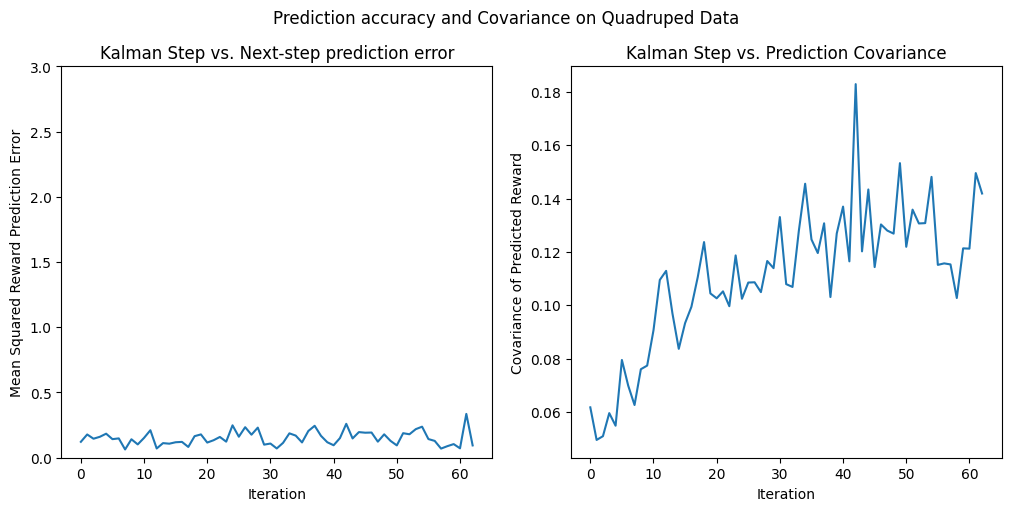

In [94]:
fig, ax = plt.subplots(1,2, figsize=(10,5), constrained_layout=True)
fig.suptitle("Prediction accuracy and Covariance on Quadruped Data")
ax[0].set_ylim(0, 3)
ax[0].plot(np.mean((actual_costs - expected_costs)**2, axis=0))
ax[0].set_ylabel("Mean Squared Reward Prediction Error")
ax[0].set_xlabel("Iteration")
ax[0].set_title("Kalman Step vs. Next-step prediction error")


ax[1].plot(np.mean((expected_variances), axis=0))
ax[1].set_title("Kalman Step vs. Prediction Covariance")
ax[1].set_ylabel("Covariance of Predicted Reward")
ax[1].set_xlabel("Iteration")
# fig.tight_layout()